# Prepare the 8760 dataset

In [1]:
#importing packages needed for analysis
import os
import numpy as np
import pandas as pd
import math
from pandas import DataFrame

path = os.getcwd()
#print(path)

load_raw = pd.read_csv('inputs/load_duration_curves_raw_data.csv')
print(load_raw.head(2))
print()
print('number of rows in dataset =', load_raw.shape[0])


     Region  Month  Day    Hour 1    Hour 2    Hour 3    Hour 4    Hour 5  \
0  ERC_REST      1    1   34,807    34,551    34,788    35,531    36,633    
1  ERC_REST      1    2   34,716    34,719    35,076    35,891    37,091    

     Hour 6    Hour 7  ...   Hour 15   Hour 16   Hour 17   Hour 18   Hour 19  \
0   37,780    38,831   ...   38,507    40,084    41,198    40,959    40,549    
1   38,207    38,720   ...   33,211    34,968    37,573    38,213    38,257    

    Hour 20   Hour 21   Hour 22   Hour 23   Hour 24  
0   39,766    38,510    37,012    35,811    35,061   
1   37,911    36,743    35,379    34,598    34,444   

[2 rows x 27 columns]

number of rows in dataset = 27010


In [2]:
#Organizing regional data

#create temporary copy to make changes on
load_org = load_raw.copy()
print('number of rows in dataset (including CN) =',load_org.shape[0])

#Regional IDs
unique_r = pd.Series(load_org['Region'].unique()).dropna()
rl = unique_r.str.split("_",n=1,expand=True)
rl[2] = unique_r
#print(rl)
print('number of regions in dataset (including CN) =',unique_r.shape[0])

#Cleaning up the empty subgroups
#print(rl[rl.isna().any(axis=1)])
rl.loc[rl[0] == 'NENGREST', 1] = 'REST'
rl.loc[rl[0] == 'FRCC', 1] = 'FRCC'

#Cleaning up the misnamed groups
#unique_g = pd.Series(rl[0].unique()).dropna()
#print(unique_g)
rl[0] = rl[0].replace('NENGREST','NENG')
rl[0] = rl[0].replace('WECC','WEC')
unique_g = pd.Series(rl[0].unique()).dropna()
print('number of regional groups in dataset (including CN) =',unique_g.shape[0])
rl.rename(columns={0 : "R_Group", 1: 'R_Subgroup', 2:'Region'},inplace=True)
#print(rl.head())

#Merging Regional Data to DF
load_org = pd.merge(rl,load_org,on='Region',how='right')
print()
print(load_org.head(2))

#Removing Canada
load_org = load_org[load_org['R_Group']!="CN"]
print()
print('number of rows in dataset after removing CN =',load_org.shape[0])
unique_r = pd.Series(load_org['Region'].unique()).dropna()
print('number of regions in dataset (excluding CN) =',unique_r.shape[0])
unique_g = pd.Series(load_org['R_Group'].unique()).dropna()
print('number of regional groups in dataset (excluding CN) =',unique_g.shape[0])




#for testing only, otherwise comment out the lines below
#NOTE: use FRCC for one region, ERC for two regions
#load_org = load_org[load_org['R_Group']=="FRCC"]
#print('number of rows in dataset for testing =',load_org.shape[0])


number of rows in dataset (including CN) = 27010
number of regions in dataset (including CN) = 74
number of regional groups in dataset (including CN) = 10

  R_Group R_Subgroup    Region  Month  Day    Hour 1    Hour 2    Hour 3  \
0     ERC       REST  ERC_REST      1    1   34,807    34,551    34,788    
1     ERC       REST  ERC_REST      1    2   34,716    34,719    35,076    

     Hour 4    Hour 5  ...   Hour 15   Hour 16   Hour 17   Hour 18   Hour 19  \
0   35,531    36,633   ...   38,507    40,084    41,198    40,959    40,549    
1   35,891    37,091   ...   33,211    34,968    37,573    38,213    38,257    

    Hour 20   Hour 21   Hour 22   Hour 23   Hour 24  
0   39,766    38,510    37,012    35,811    35,061   
1   37,911    36,743    35,379    34,598    34,444   

[2 rows x 29 columns]

number of rows in dataset after removing CN = 22995
number of regions in dataset (excluding CN) = 63
number of regional groups in dataset (excluding CN) = 9


In [3]:
#Organize temporal data

#rename hour titles to just the value ('Hour 1' --> 1)
load_org.columns = load_org.columns.str.replace('Hour ', '')
#print(load_org.head(2))

#melt function converts values in wide format to long format
load_dur = pd.melt(load_org,id_vars=['R_Group','R_Subgroup','Region','Month','Day'],var_name='Hour',value_name='Load')

#print(load_dur.dtypes)

#days are counted 1 to 365, not 1 to 31
unique_d = pd.Series(load_dur['Day'].unique()).dropna()
#print(unique_d.tail(2))

#turn hour values to numeric 
load_dur['Hour'] = pd.to_numeric(load_dur['Hour'],errors='coerce')
unique_h = pd.Series(load_dur['Hour'].unique()).dropna()
#print(unique_h.tail(2))

#add an hour counter
load_dur['Hour_Counter'] = (load_dur['Hour']) + (load_dur['Day'] - 1) * 24
load_dur = load_dur.sort_values(by=['Region','Hour_Counter'])
unique_hc = pd.Series(load_dur['Hour_Counter'].unique()).dropna()
#print(unique_hc.tail(2))

#turn load values to numeric 
load_dur['Load'] = pd.to_numeric(load_dur['Load'].str.replace(",",""),errors='coerce')
#print(load_dur.head(2))

#print(load_dur.dtypes)

season_month = pd.read_csv('inputs/season_months.csv')
load_dur = pd.merge(load_dur,season_month, on='Month', how='left')

#organized long format data to new csv file
load_dur = load_dur[['Region','R_Group','R_Subgroup','Season','Month','Day','Hour','Hour_Counter','Load']]
#load_dur.to_csv('outputs/load_long_format.csv')
print(load_dur.tail(2))
print('number of rows in dataset =',load_dur.shape[0])

          Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter  \
551878  WEC_SDGE     WEC       SDGE  winter     12  365    23          8759   
551879  WEC_SDGE     WEC       SDGE  winter     12  365    24          8760   

        Load  
551878  2362  
551879  2206  
number of rows in dataset = 551880


# Case: Normal IPM Approach (72 Representative Hours)
### Details: Split into 3 seasons, then 6 load groups, then 4 times of day
#### Methodology: Use counters to keep track of season split, then use groupby function to find load averages

In [4]:
#Assign the time of day (TOD) categories to hours

#Read in the time of day categories
tod = pd.read_csv('inputs/time_of_day.csv')
#print(tod)

#merge the time of data categories to the dataframe
load_dur_2 = pd.merge(load_dur,tod,on='Hour',how='left')
print()
print(load_dur_2.head(2))



     Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter   Load  \
0  ERC_REST     ERC       REST  winter      1    1     1             1  34807   
1  ERC_REST     ERC       REST  winter      1    1     2             2  34551   

     TOD  
0  night  
1  night  


In [5]:
#Assign the Group categories to season/hours

#Create a list of season to the 8760 hours
seasons = load_dur_2[load_dur_2['Region']==load_dur_2['Region'].iloc[0]]
seasons = seasons[['Season','Hour_Counter']]
#print(seasons.head())
#print(seasons.shape)

#get the number of hours in each season
season_count = seasons.groupby('Season',as_index=False).count().rename(columns={'Hour_Counter':'Season_Tot'})
season_count = season_count.sort_values('Season')
#print(season_count)
#print()

#read in the group shares data
group = pd.read_csv('inputs/group_shares.csv')

#combined the group shares data with the season/hours data
#NOTE: if there are ever more than three seasons, this code should be updated
group[season_count.iloc[0,0]] = group['Share']*season_count.iloc[0,1]
group[season_count.iloc[1,0]] = group['Share']*season_count.iloc[1,1]
group[season_count.iloc[2,0]] = group['Share']*season_count.iloc[2,1]
group_sea = pd.melt(group,id_vars=['Group','Share'],var_name='Seasons',value_name='Season_Ct')
group_sea['Season_Counter'] = group_sea['Season_Ct'].cumsum()
group_sea['Season_Counter'] = round(group_sea['Season_Counter'])
#print(group.dtypes)
#print(group)
#print(group_sea)
#print()

#Create a dataframe with 8760 numbers
unique_hc = pd.Series(load_dur['Hour_Counter'].unique()).dropna()
unique_hc = pd.DataFrame(unique_hc,columns=['Season_Counter'])
unique_hc['Season_Counter'] = unique_hc['Season_Counter']*1.0
season_8760 = pd.merge_asof(unique_hc, group_sea, on='Season_Counter', direction='forward')
#print(unique_hc.tail())
#print(season_8760.tail(3))
#print(season_8760.shape)
#print()


In [6]:
#Assign the load group categories to each of the 8760 hours

#Create the seasonal counter in the load dataset to merge with
load_dur_2 = load_dur_2.sort_values(['Region','Season','Load'], ascending=[True, True, False])
load_dur_2 = load_dur_2.reset_index(drop=True)
load_dur_2['Season_Counter'] = ( ( load_dur_2.index + 8760 ) % 8760 ) + 1
load_dur_2['Season_Counter'] = load_dur_2['Season_Counter'].astype(int)
#print(load_dur_2.head(2))
#print(load_dur_2.dtypes)

#Merge seasonal group data to the full dataframe
load_dur_3 = pd.merge(load_dur_2,season_8760,on='Season_Counter',how='left')
load_dur_3 = load_dur_3.drop(columns=['Share','Seasons','Season_Ct'])
#load_dur_3.to_csv('outputs/load_duration_8760_NORM.csv')
print(load_dur_3.head(2))
print()
print(load_dur_3.tail(2))
print()
print('number of rows in dataset =',load_dur_3.shape[0])


     Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
0  ERC_REST     ERC       REST  shoulder     10  278    15          6663   
1  ERC_REST     ERC       REST  shoulder     10  278    14          6662   

    Load      TOD  Season_Counter  Group  
0  57777  middday               1      1  
1  57380  middday               2      1  

          Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter  \
551878  WEC_SDGE     WEC       SDGE  winter      2   38     3           891   
551879  WEC_SDGE     WEC       SDGE  winter      1   17     3           387   

        Load    TOD  Season_Counter  Group  
551878  1703  night            8759      6  
551879  1697  night            8760      6  

number of rows in dataset = 551880


In [7]:
load_dur_3 = load_dur_3.sort_values(['Region','Season','Group','TOD'])

aggregations = {'Load':['count',sum,'mean']}
norm = load_dur_3.groupby(['Region','Season','Group','TOD'],as_index=False).agg(aggregations)
norm.columns = norm.columns.droplevel(0)
norm.columns = ['Region','Season','Group','TOD','Hour_Tot','Load_Tot','Load_Avg']
print(norm.head(3))
print('number of rows in dataset =',norm.shape[0])
#norm.to_csv('outputs/load_segments_NORM.csv')
print()

load_dur_4 = pd.merge(load_dur_3,norm,on=['Region','Season','Group','TOD'],how='left')
load_dur_4 = load_dur_4.sort_values(['Region','Load'])
print(load_dur_4.head(3))
print('number of rows in dataset =',load_dur_4.shape[0])
#load_dur_4.to_csv('outputs/load_8760_NORM.csv')


     Region    Season  Group      TOD  Hour_Tot  Load_Tot      Load_Avg
0  ERC_REST  shoulder      1  evening         2    107834  53917.000000
1  ERC_REST  shoulder      1  middday        27   1482630  54912.222222
2  ERC_REST  shoulder      2  evening        34   1693417  49806.382353
number of rows in dataset = 4169

        Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
2927  ERC_REST     ERC       REST  shoulder      3   86     3          2043   
2926  ERC_REST     ERC       REST  shoulder      4   94     2          2234   
2925  ERC_REST     ERC       REST  shoulder      3   72     3          1707   

       Load    TOD  Season_Counter  Group  Hour_Tot  Load_Tot      Load_Avg  
2927  26989  night            2928      6       661  19467771  29451.998487  
2926  27006  night            2927      6       661  19467771  29451.998487  
2925  27025  night            2926      6       661  19467771  29451.998487  
number of rows in dataset = 551880


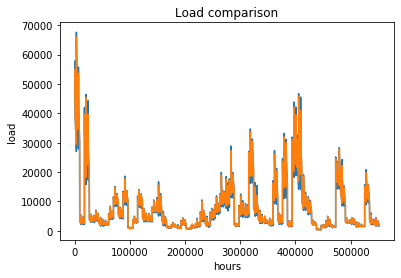

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

load_dur_4 = load_dur_4.sort_values(by=['Region','Season_Counter'])
plt.plot(load_dur_4['Load'].values)
plt.title('IPM modeled load')
plt.xlabel('Hours')
plt.ylabel('Load')

load_dur_4 = load_dur_4.sort_values(by=['Region','Season','Load_Avg'],ascending=[True, True, False])
plt.plot(load_dur_4['Load_Avg'].values)
plt.title('Load comparison')
plt.xlabel('hours')
plt.ylabel('load')

plt.show()

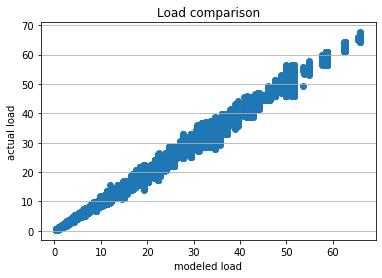

In [9]:
fig, axis = plt.subplots()

axis.yaxis.grid(True)
axis.set_title('Load comparison')
axis.set_xlabel('modeled load')
axis.set_ylabel('actual load')

X = load_dur_4['Load_Avg']/1000
Y = load_dur_4['Load']/1000

axis.scatter(X, Y)
plt.show()

# Case: Grouping Time of Day before Load Group
### Details: Regions will be split first by season, then time of day, then load group
#### Methodology: Use same methods & code as norm case, but switch order of groupby for group and time of day

In [13]:
#Assign the time of day (TOD) categories to hours

#Read in the time of day categories
tod = pd.read_csv('inputs/time_of_day.csv')
#print(tod)

#merge the time of data categories to the dataframe
tod_load = pd.merge(load_dur,tod,on='Hour',how='left')
print()
print(tod_load.head(2))



     Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter   Load  \
0  ERC_REST     ERC       REST  winter      1    1     1             1  34807   
1  ERC_REST     ERC       REST  winter      1    1     2             2  34551   

     TOD  
0  night  
1  night  


In [14]:
#Assign the Group categories to season/hours

#Create a list of season to the 8760 hours
seasons2 = tod_load[tod_load['Region']==tod_load['Region'].iloc[0]]
seasons2 = seasons2[['Season','Hour_Counter']]
#print(seasons2.head())
#print(seasons2.shape)

#get the number of hours in each season
season2_count = seasons2.groupby('Season',as_index=False).count().rename(columns={'Hour_Counter':'Season_Tot'})
season2_count = season2_count.sort_values('Season')
#print(season2_count)
#print()

#read in the group shares data
group3 = pd.read_csv('inputs/group_shares.csv')

#combined the group shares data with the season/hours data
#NOTE: if there are ever more than three seasons, this code should be updated
group3[season2_count.iloc[0,0]] = group3['Share']*season2_count.iloc[0,1]
group3[season2_count.iloc[1,0]] = group3['Share']*season2_count.iloc[1,1]
group3[season2_count.iloc[2,0]] = group3['Share']*season2_count.iloc[2,1]
group2_sea = pd.melt(group3,id_vars=['Group','Share'],var_name='Seasons',value_name='Season_Ct')
group2_sea['Season_Counter'] = group2_sea['Season_Ct'].cumsum()
group2_sea['Season_Counter'] = round(group2_sea['Season_Counter'])
#print(group.dtypes)
#print(group)
#print(group_sea)
#print()

#Create a dataframe with 8760 numbers
unique_hc2 = pd.Series(load_dur['Hour_Counter'].unique()).dropna()
unique_hc2 = pd.DataFrame(unique_hc2,columns=['Season_Counter'])
unique_hc2['Season_Counter'] = unique_hc2['Season_Counter']*1.0
season2_8760 = pd.merge_asof(unique_hc2, group2_sea, on='Season_Counter', direction='forward')
#print(unique_hc.tail())
#print(season_8760.tail(3))
#print(season_8760.shape)
#print()

In [15]:
#Assign the load group categories to each of the 8760 hours

#Create the seasonal counter in the load dataset to merge with
tod_load = tod_load.sort_values(['Region','Season','Load'], ascending=[True, True, False])
tod_load = tod_load.reset_index(drop=True)
tod_load['Season_Counter'] = ( ( tod_load.index + 8760 ) % 8760 ) + 1
tod_load['Season_Counter'] = tod_load['Season_Counter'].astype(int)
#print(tod_load.head(2))
#print(tod_load.dtypes)

#Merge seasonal group data to the full dataframe
tod_load_2 = pd.merge(tod_load,season2_8760,on='Season_Counter',how='left')
tod_load_2 = tod_load_2.drop(columns=['Share','Seasons','Season_Ct'])
#tod_load_2.to_csv('outputs/load_duration_8760_timeofday.csv')
print(tod_load_2.head(2))
print()
print(tod_load_2.tail(2))
print()
print('number of rows in dataset =',tod_load_2.shape[0])


     Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
0  ERC_REST     ERC       REST  shoulder     10  278    15          6663   
1  ERC_REST     ERC       REST  shoulder     10  278    14          6662   

    Load      TOD  Season_Counter  Group  
0  57777  middday               1      1  
1  57380  middday               2      1  

          Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter  \
551878  WEC_SDGE     WEC       SDGE  winter      2   38     3           891   
551879  WEC_SDGE     WEC       SDGE  winter      1   17     3           387   

        Load    TOD  Season_Counter  Group  
551878  1703  night            8759      6  
551879  1697  night            8760      6  

number of rows in dataset = 551880


In [16]:
tod_load_2 = tod_load_2.sort_values(['Region','Season','TOD','Group'])

aggregations = {'Load':['count',sum,'mean']}
case2 = tod_load_2.groupby(['Region','Season','TOD','Group'],as_index=False).agg(aggregations)
case2.columns = case2.columns.droplevel(0)
case2.columns = ['Region','Season','TOD','Group','Hour_Tot','Load_Tot','Load_Avg']
print(case2.head(3))
print('number of rows in dataset =',case2.shape[0])
#case2.to_csv('outputs/load_segments_timeofday.csv')
print()

tod_load_3 = pd.merge(tod_load_2,case2,on=['Region','Season','TOD','Group'],how='left')
tod_load_3 = tod_load_3.sort_values(['Region','Load'])
print(tod_load_3.head(3))
print('number of rows in dataset =',tod_load_3.shape[0])
#tod_load_3.to_csv('outputs/load_8760_timeofday.csv')


     Region    Season      TOD  Group  Hour_Tot  Load_Tot      Load_Avg
0  ERC_REST  shoulder  evening      1         2    107834  53917.000000
1  ERC_REST  shoulder  evening      2        34   1693417  49806.382353
2  ERC_REST  shoulder  evening      3        76   3345487  44019.565789
number of rows in dataset = 4169

        Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
2927  ERC_REST     ERC       REST  shoulder      3   86     3          2043   
2926  ERC_REST     ERC       REST  shoulder      4   94     2          2234   
2925  ERC_REST     ERC       REST  shoulder      3   72     3          1707   

       Load    TOD  Season_Counter  Group  Hour_Tot  Load_Tot      Load_Avg  
2927  26989  night            2928      6       661  19467771  29451.998487  
2926  27006  night            2927      6       661  19467771  29451.998487  
2925  27025  night            2926      6       661  19467771  29451.998487  
number of rows in dataset = 551880


### Plot of a single region

In [ ]:
#plot when testing a single region 
%matplotlib inline
import matplotlib.pyplot as plt

tod_load_3 = tod_load_3.sort_values(by=['Region','Season_Counter'])
plt.plot(tod_load_3['Load'].values)
plt.title('IPM modeled load')
plt.xlabel('Hours')
plt.ylabel('Load')

tod_load_3 = tod_load_3.sort_values(by=['Region','Season','Load_Avg'],ascending=[True, True, False])
plt.plot(tod_load_3['Load_Avg'].values)
plt.title('Load comparison')
plt.xlabel('hours')
plt.ylabel('load')

plt.show()